In [1]:
import pandas as pd
import os
import re
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import nltk
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
from nltk.corpus import stopwords
from pprint import pprint
import pyLDAvis.gensim
import pickle
import pyLDAvis
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sburc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sburc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [34]:
constituencies_df = pd.read_csv("constituencies_by_region.csv")
constituencies_df = constituencies_df[["PCON22NM", "constituency_by_region.shpRGN22NM"]]
constituencies_df.rename(columns={"PCON22NM": "constName", "constituency_by_region.shpRGN22NM": "regionName"}, inplace=True)
constituencies_df.head()

,constName,regionName
0,Aldershot,South East
1,Aldridge-Brownhills,West Midlands
2,Altrincham and Sale West,North West
3,Amber Valley,East Midlands
4,Arundel and South Downs,South East


In [38]:
const_dict = {k:v for k,v in zip(constituencies_df['constName'], constituencies_df["regionName"])}
print(const_dict)
print(len(const_dict))


{'Aldershot': 'South East', 'Aldridge-Brownhills': 'West Midlands', 'Altrincham and Sale West': 'North West', 'Amber Valley': 'East Midlands', 'Arundel and South Downs': 'South East', 'Ashfield': 'East Midlands', 'Ashford': 'South East', 'Ashton-under-Lyne': 'North West', 'Aylesbury': 'South East', 'Banbury': 'South East', 'Barking': 'London', 'Barnsley Central': 'Yorkshire and The Humber', 'Barnsley East': 'Yorkshire and The Humber', 'Barrow and Furness': 'North West', 'Basildon and Billericay': 'East of England', 'Basingstoke': 'South East', 'Bassetlaw': 'East Midlands', 'Bath': 'South West', 'Batley and Spen': 'Yorkshire and The Humber', 'Battersea': 'London', 'Beaconsfield': 'South East', 'Beckenham': 'London', 'Bedford': 'East of England', 'Bermondsey and Old Southwark': 'London', 'Berwick-upon-Tweed': 'North East', 'Bethnal Green and Bow': 'London', 'Beverley and Holderness': 'Yorkshire and The Humber', 'Bexhill and Battle': 'South East', 'Bexleyheath and Crayford': 'London', 'Bi

In [2]:
questions_df = pd.read_csv('questionsQuery.csv', quotechar='"', skipinitialspace=True, encoding="utf-8")
print(questions_df.shape[1])

questions_df = questions_df.loc[:, ~questions_df.columns.str.contains('^Unnamed')]

def remove_whitespace(df):
    df.rename(str.strip, axis="columns", inplace=True)
    for i in df.columns:
        df[i] = df[i].str.strip()
        if i == "text":
            df[i] = df[i].map(lambda x: x[3:-4])


# REMOVE WHITE SPACE FROM DATAFRAME
print(questions_df.columns)
remove_whitespace(questions_df)
print(questions_df.columns)

questions_df.head()

16
Index(['question ', 'qnum ', 'text ', 'date ', 'person ', 'name ', 'surname ',
       'seatIncumbency ', 'seat ', 'constituency ', 'house ', 'houseName ',
       'seatIncumbencyStartDate ', 'constituencyName ',
       'constituencyStartDate '],
      dtype='object')
Index(['question', 'qnum', 'text', 'date', 'person', 'name', 'surname',
       'seatIncumbency', 'seat', 'constituency', 'house', 'houseName',
       'seatIncumbencyStartDate', 'constituencyName', 'constituencyStartDate'],
      dtype='object')


,question,qnum,text,date,person,name,surname,seatIncumbency,seat,constituency,house,houseName,seatIncumbencyStartDate,constituencyName,constituencyStartDate
0,https://id.parliament.uk/0IwOO533,903422,Which three departments had the lowest proport...,2023-01-05+00:00,https://id.parliament.uk/Vs3bGLNz,Philip,Hollobone,https://id.parliament.uk/wiR0TXEx,https://id.parliament.uk/tpDcfKEU,https://id.parliament.uk/79YObEMl,https://id.parliament.uk/1AFu55Hs,House of Commons,2019-12-12+00:00,Kettering,2010-05-06+01:00
1,https://id.parliament.uk/dRJ9254g,117748,"To ask the Secretary of State for Foreign, Com...",2023-01-06+00:00,https://id.parliament.uk/eD0yd5Ec,Catherine,West,https://id.parliament.uk/TbtymCvC,https://id.parliament.uk/cR4IWVwp,https://id.parliament.uk/H2TVOJgH,https://id.parliament.uk/1AFu55Hs,House of Commons,2019-12-12+00:00,Hornsey and Wood Green,2010-05-06+01:00
2,https://id.parliament.uk/e4IDRkKi,117410,"To ask the Secretary of State for Foreign, Com...",2023-01-06+00:00,https://id.parliament.uk/RlIqlixq,Timothy,Loughton,https://id.parliament.uk/UWWa5GU5,https://id.parliament.uk/OEV2U2ZQ,https://id.parliament.uk/YqIfQuKs,https://id.parliament.uk/1AFu55Hs,House of Commons,2019-12-12+00:00,East Worthing and Shoreham,2010-05-06+01:00
3,https://id.parliament.uk/rXZ0r1JW,117477,"To ask the Secretary of State for Foreign, Com...",2023-01-06+00:00,https://id.parliament.uk/1DzMUkBy,Fabian,Hamilton,https://id.parliament.uk/I8imum8M,https://id.parliament.uk/8dnnjjvi,https://id.parliament.uk/EH8hmrNu,https://id.parliament.uk/1AFu55Hs,House of Commons,2019-12-12+00:00,Leeds North East,2010-05-06+01:00
4,https://id.parliament.uk/SmC4cGhg,117777,To ask the Secretary of State for Health and S...,2023-01-06+00:00,https://id.parliament.uk/tOfis7j9,Sarah,Olney,https://id.parliament.uk/XQNx9njJ,https://id.parliament.uk/UVpLA3KR,https://id.parliament.uk/MDExJLK4,https://id.parliament.uk/1AFu55Hs,House of Commons,2019-12-12+00:00,Richmond Park,2010-05-06+01:00


In [3]:
# COUNT AND REMOVE NON-MPs
total_questions = questions_df.shape[0]
questions_df.dropna(subset=['seatIncumbency', 'seat', 'constituency', 'house', 'houseName',
       'seatIncumbencyStartDate', 'constituencyName', 'constituencyStartDate'], inplace=True)
questions_df.reset_index(drop=True, inplace=True)

mps_only_count = questions_df.shape[0]

print("number of non-mp questions:", total_questions - mps_only_count)

number of non-mp questions: 2393


In [4]:
questions_df = questions_df[['text', "constituencyName"]]
questions_df.head()

,text,constituencyName
0,Which three departments had the lowest proport...,Kettering
1,"To ask the Secretary of State for Foreign, Com...",Hornsey and Wood Green
2,"To ask the Secretary of State for Foreign, Com...",East Worthing and Shoreham
3,"To ask the Secretary of State for Foreign, Com...",Leeds North East
4,To ask the Secretary of State for Health and S...,Richmond Park


In [ ]:
# assign region to each question
questions_df['regionName'] = questions_df.constituencyName.map(lambda x: const_dict[x])
questions_df['regionName']

In [5]:
# REMOVE PUNCTUATION AND CONVERT TO LOWER CASE

questions_df['text_processed'] = questions_df['text'].map(lambda x: re.sub('[,\\.!\/?:;()\[\]]', "", x))
questions_df['text_processed'] = questions_df['text_processed'].map(lambda x: x.lower())

print(questions_df.loc[0, "text_processed"])
questions_df.head()

which three departments had the lowest proportion of staff attending the office in january 2023


<>:3: DeprecationWarning: invalid escape sequence '\/'
<>:3: DeprecationWarning: invalid escape sequence '\/'
C:\Users\sburc\AppData\Local\Temp\ipykernel_2200\3744966746.py:3: DeprecationWarning: invalid escape sequence '\/'
  questions_df['text_processed'] = questions_df['text'].map(lambda x: re.sub('[,\\.!\/?:;()\[\]]', "", x))


,text,constituencyName,text_processed
0,Which three departments had the lowest proport...,Kettering,which three departments had the lowest proport...
1,"To ask the Secretary of State for Foreign, Com...",Hornsey and Wood Green,to ask the secretary of state for foreign comm...
2,"To ask the Secretary of State for Foreign, Com...",East Worthing and Shoreham,to ask the secretary of state for foreign comm...
3,"To ask the Secretary of State for Foreign, Com...",Leeds North East,to ask the secretary of state for foreign comm...
4,To ask the Secretary of State for Health and S...,Richmond Park,to ask the secretary of state for health and s...


In [6]:
unique_words = set().union(*questions_df['text_processed'].map(lambda x: x.split()))
print(unique_words)
print(f"unique words: {len(unique_words)}")

{'purchase', 'intended', '193249', 'o’shaughnessy', 'booked', 'harms', 'sliding', 'never', '156196', 'depart', 'mpam051056923', 'rubbish', 'many', "huntington's", 'sudanese', 'celebrants', 'grassroots', 'unaccounted', 'storm', 'domestic-based', 'co2', 'biochar', 'malatya', 'keyworker', 'oand', 'reused', 'flexitime', 'founded', 'chose', 'organic', 'marginalisation', 'accident', 'permit', '59', 'anti-muslim', 'billion', 'classed', 'killing', 'animals', 'relatively', '185575', 'dosages', 'witnesses', 'auxiliary’s', 'tel-aviv', 'screening', 'retention', 'declared', 'anaemia', 'non-visible', 'awaiting', 'initiated', '191621', 'ensures', 'radiologists', 'gaza', 'sanctioned', 'redirect', 'space', 'psychologists', 'treaty', 'weblinks', 'outages', 'repairing', 'safeguarded', 'preferences', 'recently', 'curricular', 'bridlington', 'utilise', 'iranian-linked', 'expanding', 'parsley', 'syndrome-specific', 'accepted', 'astute-class', 'disconnected', 'wastes', '183644', 'wandle', 'electronics', 'wai

In [7]:
# # Example for detecting bigrams 
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder\
.from_documents([question.split() for question in questions_df.text_processed])

# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)
print(bigram_scores)

[(('hong', 'kong'), 13.771617641673961), (('bedfordshire', 'representing'), 12.886062996892218), (('broken', 'down'), 12.817198675982855), (('ticket', 'offices'), 12.793217178280127), (('artificial', 'intelligence'), 12.628631883543004), (('offshore', 'wind'), 12.571124701908879), (('church', 'commissioners'), 12.504263446027455), (('great', 'britain'), 12.424731129560143), (('relevant', 'a-level'), 12.273444153268194), (('qualified', 'teacher'), 12.210729275931664), (('civil', 'servants'), 12.094912572325228), (('bring', 'forward'), 12.021595894682308), (('illegal', 'migration'), 11.984387824211666), (('prepayment', 'meters'), 11.966161315107856), (('animal', 'welfare'), 11.931841241923978), (('minimum', 'wage'), 11.916940669883195), (('per', 'cent'), 11.810387211838536), (('afghan', 'relocations'), 11.801512191337297), (('long', 'term'), 11.798467967318771), (('construction', 'element'), 11.788105764462529), (('oral', 'contribution'), 11.756269677340526), (('active', 'travel'), 11.75

In [8]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([question.split() for question in questions_df.text_processed])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)
print(trigram_scores)

[(('qualified', 'teacher', 'status'), 24.298820582400875), (('west', 'bedfordshire', 'representing'), 24.292683821786923), (('bring', 'forward', 'legislative'), 23.948864406816462), (('one', 'construction', 'element'), 23.581749712466486), (('forward', 'legislative', 'proposals'), 23.525821444835238), (('least', 'one', 'construction'), 23.35935729113004), (('retained', 'eu', 'law'), 23.012970723290675), (('south', 'west', 'bedfordshire'), 22.804639464341548), (('dit', 'spending', 'over'), 22.726726752001888), (('spending', 'over', '£25000'), 22.686616538627735), (('healthcare', 'products', 'regulatory'), 22.644537437331046), (('personal', 'independence', 'payment'), 22.58234003270687), (('free', 'school', 'meals'), 22.447208602572413), (('relevant', 'a-level', 'or'), 22.349675304527352), (('languages', 'were', 'taught'), 22.341108710477037), (('spending', 'over', '£500'), 22.32354561041283), (('rt', 'hon', 'member'), 22.196474083383553), (('products', 'regulatory', 'agency'), 22.107845

In [9]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
bigram_pmi.head()

,bigram,pmi
0,"(hong, kong)",13.771618
1,"(bedfordshire, representing)",12.886063
2,"(broken, down)",12.817199
3,"(ticket, offices)",12.793217
4,"(artificial, intelligence)",12.628632


In [10]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
trigram_pmi.head()

,trigram,pmi
0,"(qualified, teacher, status)",24.298821
1,"(west, bedfordshire, representing)",24.292684
2,"(bring, forward, legislative)",23.948864
3,"(one, construction, element)",23.581750
4,"(forward, legislative, proposals)",23.525821


In [11]:
stop_words = stopwords.words("english")

# Example filter for noun-type structures bigrams
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_words or bigram[1] in stop_words:
        return False
    if 'PRON' in bigram:
        print(bigram)
        return False
    return True

# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_words or trigram[-1] in stop_words or trigram[1] in stop_words:
        return False
    if 'PRON' in trigram:
        print(trigram)
        return False
    return True 

In [12]:
# Can eyeball list and choose PMI threshold where n-grams stop making sense
# In this case, get top 500 bigrams/trigrams with highest PMI score
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram: bigram_filter(bigram['bigram']) and bigram.pmi > 5, axis = 1)]
print(filtered_bigram)

bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]

                           bigram        pmi
0                    (hong, kong)  13.771618
1    (bedfordshire, representing)  12.886063
3               (ticket, offices)  12.793217
4      (artificial, intelligence)  12.628632
5                (offshore, wind)  12.571125
..                            ...        ...
444              (sport, whether)   5.182491
455          (strategy, pursuant)   5.100954
461               (primary, care)   5.061153
463                 (march, 2021)   5.059998
473         (strategy, published)   5.006740

[233 rows x 2 columns]


In [13]:
filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)][:500]
print(filtered_trigram)
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

                                trigram        pmi
0          (qualified, teacher, status)  24.298821
1    (west, bedfordshire, representing)  24.292684
3          (one, construction, element)  23.581750
4     (forward, legislative, proposals)  23.525821
6                   (retained, eu, law)  23.012971
..                                  ...        ...
351    (development, affairs, pursuant)  12.350414
370            (social, care, pursuant)  12.172402
386             (social, care, whether)  12.028524
414        (home, department, pursuant)  11.861588
537         (home, department, whether)  11.041898

[74 rows x 2 columns]


In [14]:
def replace_ngram(x):
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

questions_df.text_processed = questions_df.text_processed\
.map(lambda x: replace_ngram(x))

questions_df.head()

,text,constituencyName,text_processed
0,Which three departments had the lowest proport...,Kettering,which three departments had the lowest proport...
1,"To ask the Secretary of State for Foreign, Com...",Hornsey and Wood Green,to ask the secretary of state for foreign_comm...
2,"To ask the Secretary of State for Foreign, Com...",East Worthing and Shoreham,to ask the secretary of state for foreign_comm...
3,"To ask the Secretary of State for Foreign, Com...",Leeds North East,to ask the secretary of state for foreign_comm...
4,To ask the Secretary of State for Health and S...,Richmond Park,to ask the secretary of state for health and s...


In [16]:
# Tokenize reviews + remove stop words + remove words with less than 2 characters
# questions_df.text_processed = questions_df.text_processed.map(lambda x: [word for word in x.split() if word not in stop_words and len(word) > 2])
# questions_df.head()

,text,constituencyName,text_processed
0,Which three departments had the lowest proport...,Kettering,"[three, departments, lowest, proportion, staff..."
1,"To ask the Secretary of State for Foreign, Com...",Hornsey and Wood Green,"[ask, secretary, state, foreign_commonwealth, ..."
2,"To ask the Secretary of State for Foreign, Com...",East Worthing and Shoreham,"[ask, secretary, state, foreign_commonwealth, ..."
3,"To ask the Secretary of State for Foreign, Com...",Leeds North East,"[ask, secretary, state, foreign_commonwealth, ..."
4,To ask the Secretary of State for Health and S...,Richmond Park,"[ask, secretary, state, health, social_care, m..."


In [118]:
# Filter for only nouns
# def noun_only(x):
#     pos_question = nltk.pos_tag(x)
#     filtered =[word[0] for word in pos_question if word[1] in ['NN']]
#     return filtered
# questions = questions_df.text_processed.values.tolist()
#print(questions)


c:\Users\sburc\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
c:\Users\sburc\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:523: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
c:\Users\sburc\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\Users\sburc\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_

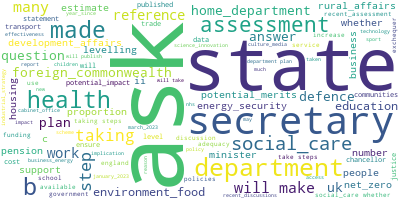

In [15]:
long_string = ",".join(questions_df['text_processed'].values)

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color="steelblue")
wordcloud.generate(long_string)

wordcloud.to_image()


In [16]:
stop_words.extend(["ask", "state", "secretary", "department", "made", "whether", "many", "make", "question", "answer", "take", "use", "since", "new", "much"])
    
def parse_questions(texts):
    return [[word for word in simple_preprocess(str(q), deacc=True) if word not in stop_words and len(word) > 2] for q in texts]

# get list of questions
# train_set, test_set = train_test_split(questions_df, test_size=0.2, random_state=0, shuffle=True)
# questions_train = train_set.text_processed.values.tolist()
# questions_test = test_set.text_processed.values.tolist()
questions = questions_df.text_processed.values.tolist()

# turn questions into list of words (tokens) and remove stop words
# train_words = parse_questions(questions_train)
# test_words = parse_questions(questions_test)
words = parse_questions(questions)
print(questions_df.loc[0, "text_processed"])
print(words[:1][0])

which three departments had the lowest proportion of staff attending the office in january_2023
['three', 'departments', 'lowest', 'proportion', 'staff', 'attending', 'office', 'january_']


In [17]:
counter = Counter(words[0])
for question in words[1:]:
    counter.update(question)

counter.most_common(100)

[('health', 5658),
 ('social_care', 4774),
 ('steps', 4678),
 ('assessment', 4508),
 ('taking', 3294),
 ('plans', 2377),
 ('work', 2371),
 ('home_department', 2273),
 ('reference', 2241),
 ('defence', 2159),
 ('education', 1769),
 ('support', 1623),
 ('rural_affairs', 1599),
 ('pensions', 1522),
 ('people', 1471),
 ('net_zero', 1361),
 ('housing', 1345),
 ('published', 1335),
 ('number', 1332),
 ('government', 1309),
 ('trade', 1285),
 ('energy_security', 1273),
 ('business', 1247),
 ('years', 1200),
 ('data', 1196),
 ('pursuant', 1141),
 ('nhs', 1104),
 ('minister', 1089),
 ('estimate', 1081),
 ('proportion', 1063),
 ('justice', 1040),
 ('communities', 1026),
 ('funding', 998),
 ('england', 995),
 ('levelling', 966),
 ('transport', 954),
 ('scheme', 953),
 ('publish', 890),
 ('ensure', 869),
 ('service', 845),
 ('statement', 843),
 ('services', 837),
 ('exchequer', 832),
 ('chancellor', 826),
 ('cost', 776),
 ('discussions', 756),
 ('staff', 747),
 ('impact', 747),
 ('children', 746),

In [18]:
unique_words = set().union(*words)
print(unique_words)
print(f"unique words: {len(unique_words)}")

{'purchase', 'intended', 'booked', 'harms', 'sliding', 'never', 'depart', 'rubbish', 'sudanese', 'celebrants', 'grassroots', 'unaccounted', 'storm', 'biochar', 'malatya', 'keyworker', 'oand', 'reused', 'founded', 'chose', 'organic', 'running_cost', 'marginalisation', 'accident', 'permit', 'billion', 'classed', 'killing', 'animals', 'relatively', 'dosages', 'witnesses', 'screening', 'retention', 'declared', 'anaemia', 'awaiting', 'initiated', 'ensures', 'radiologists', 'primary_care', 'gaza', 'sanctioned', 'redirect', 'space', 'psychologists', 'treaty', 'weblinks', 'outages', 'repairing', 'safeguarded', 'preferences', 'recently', 'commemoration', 'curricular', 'bridlington', 'utilise', 'expanding', 'parsley', 'accepted', 'disconnected', 'wastes', 'wandle', 'electronics', 'waited', 'storage', 'gorton', 'leith', 'redeem', 'earthquake', 'ambitions', 'conduct', 'shooting', 'productive', 'beneficial', 'homicides', 'caught', 'failures', 'royston', 'marking', 'fare', 'woodvale', 'guards', 'fra

In [19]:
# create a dictonary of ids from the words in the corpus (list of questions)
id2word = corpora.Dictionary(words)
questions = words
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below=20, no_above=0.5)

# convert each question into bag of words (where words are ids based on dictionary)
corpus = [id2word.doc2bow(question) for question in questions]
# train_corpus = [id2word.doc2bow(question) for question in questions_train]
# test_corpus = [id2word.doc2bow(question) for question in questions_test]

print(corpus[:1][0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]


In [ ]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

In [36]:
import logging
for handler in logging.root.handlers[:]:
   logging.root.removeHandler(handler)
logging.basicConfig(filename="lda_model.log", format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [20]:
num_topics = 10
iters = 200
passes = 40
chunksize = questions_df.shape[0] // 2
random_state = 42

base_model = gensim.models.LdaModel(corpus=corpus, 
                                       id2word=id2word, 
                                       num_topics=num_topics, iterations=iters, passes=passes, chunksize=chunksize, random_state=random_state)

pprint(base_model.print_topics())
doc_lda = base_model[corpus]

[(0,
  '0.174*"habitat" + 0.108*"period" + 0.090*"amount" + 0.088*"commitments" + '
  '0.087*"nature" + 0.087*"biodiversity" + 0.087*"net" + 0.070*"destroyed" + '
  '0.061*"implementation" + 0.047*"small"'),
 (1,
  '0.007*"sourced" + 0.006*"endoscopy" + 0.006*"employing" + 0.006*"topical" + '
  '0.005*"scampton" + 0.004*"guided" + 0.004*"fibrosis" + 0.004*"enhancement" '
  '+ 0.004*"version" + 0.004*"indo"'),
 (2,
  '0.098*"small" + 0.067*"created" + 0.067*"gain" + 0.067*"compact" + '
  '0.065*"sites" + 0.065*"amount" + 0.064*"decision" + 0.064*"meet" + '
  '0.064*"developers" + 0.062*"ability"'),
 (3,
  '0.089*"health" + 0.075*"social_care" + 0.027*"education" + 0.025*"steps" + '
  '0.018*"taking" + 0.017*"nhs" + 0.016*"assessment" + 0.011*"services" + '
  '0.010*"schools" + 0.009*"care"'),
 (4,
  '0.009*"comprehensive" + 0.007*"federated" + 0.007*"shortage" + '
  '0.007*"progressive" + 0.005*"accept" + 0.005*"trees" + 0.005*"merger" + '
  '0.004*"particulate" + 0.004*"american" + 0.0

In [21]:
cm = gensim.models.coherencemodel.CoherenceModel(model=base_model, texts=questions,\
                                                     dictionary=id2word, coherence='c_v')
print(cm.get_coherence())

c:\Users\sburc\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
c:\Users\sburc\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
c:\Users\sburc\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and

0.470525456329505


In [22]:
cv_coherence = []
umass_coherence = []
perplexity = []
for k in range(5,25):
    ldamodel = gensim.models.LdaModel(corpus, num_topics=k, id2word = id2word, passes=40,\
                   iterations=200, chunksize = chunksize, random_state=random_state, eval_every = None)
    
    cv_cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=questions,\
                                                     dictionary=id2word, coherence='c_v')
    umass_cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=questions,\
                                                     dictionary=id2word, coherence='u_mass')
    
    print(k, cv_cm.get_coherence(), umass_cm.get_coherence())
    cv_coherence.append((k,cv_cm.get_coherence()))
    umass_coherence.append((k, umass_cm.get_coherence()))

5 0.4499748954840442 -6.545744266686161
6 0.4324554056650211 -4.988802413315692
7 0.43313899083149615 -7.145197103866053
8 0.47299453083818954 -7.997507522791263
9 0.3850997287085881 -5.323846959318432
10 0.46738495855977147 -7.793308671868424
11 0.4491857064945375 -7.30596607328778
12 0.44693028065375645 -8.38199010264612
13 0.4628838531826952 -10.223183992665978
14 0.45656167682907567 -8.054324972549091
15 0.42963097281232837 -8.591683851185026
16 0.43629768844116545 -7.939732434095273
17 0.4266272946926971 -7.335965264931322
18 0.41524475924348964 -7.10348624483442
19 0.4353460732708336 -8.820063095027415
20 0.3874474707141399 -6.918124816517033
21 0.4279005306442134 -8.063098465844286
22 0.4148328725515311 -6.645511306179336
23 0.44549084808187694 -7.559341589039831
24 0.4166225094587653 -8.169480809382385


In [23]:
print(cv_coherence)
print(umass_coherence)

[(5, 0.4499748954840442), (6, 0.4324554056650211), (7, 0.43313899083149615), (8, 0.47299453083818954), (9, 0.3850997287085881), (10, 0.46738495855977147), (11, 0.4491857064945375), (12, 0.44693028065375645), (13, 0.4628838531826952), (14, 0.45656167682907567), (15, 0.42963097281232837), (16, 0.43629768844116545), (17, 0.4266272946926971), (18, 0.41524475924348964), (19, 0.4353460732708336), (20, 0.3874474707141399), (21, 0.4279005306442134), (22, 0.4148328725515311), (23, 0.44549084808187694), (24, 0.4166225094587653)]
[(5, -6.545744266686161), (6, -4.988802413315692), (7, -7.145197103866053), (8, -7.997507522791263), (9, -5.323846959318432), (10, -7.793308671868424), (11, -7.30596607328778), (12, -8.38199010264612), (13, -10.223183992665978), (14, -8.054324972549091), (15, -8.591683851185026), (16, -7.939732434095273), (17, -7.335965264931322), (18, -7.10348624483442), (19, -8.820063095027415), (20, -6.918124816517033), (21, -8.063098465844286), (22, -6.645511306179336), (23, -7.55934

In [24]:
x_val = [x[0] for x in cv_coherence]
cv_val = [x[1] for x in cv_coherence]
umass_val = [x[1] for x in umass_coherence]

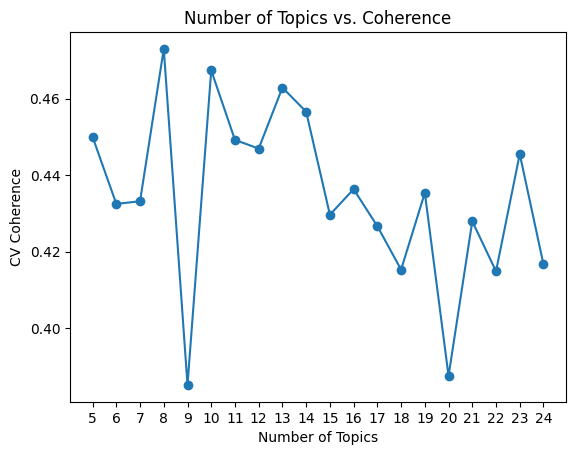

In [25]:
plt.plot(x_val,cv_val)
plt.scatter(x_val,cv_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('CV Coherence')
plt.xticks(x_val)
plt.show()

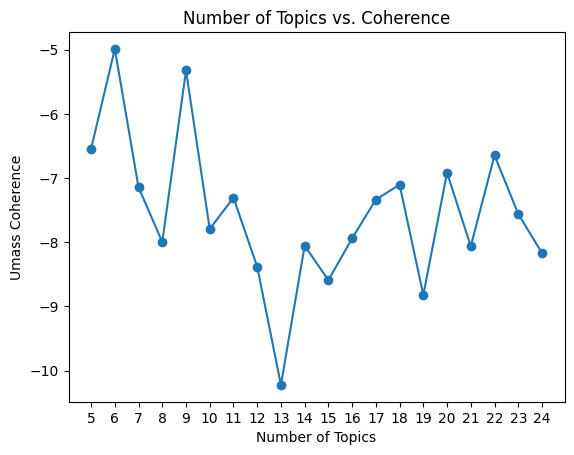

In [26]:
plt.plot(x_val,umass_val)
plt.scatter(x_val,umass_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Umass Coherence')
plt.xticks(x_val)
plt.show()

In [39]:
# TRAIN THE MODEL (adjusted parameters)
num_topics = 8
iters = 200 # number of iterations over each document
passes = 40 # number of passes through the entire corpus

lda_model = gensim.models.LdaModel(corpus=corpus, 
                                       id2word=id2word, alpha="auto", eta="auto", 
                                       num_topics=num_topics, iterations=iters, chunksize=chunksize, passes=passes, random_state=random_state)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.016*"nuclear" + 0.012*"storage" + 0.011*"power" + 0.009*"infected" + '
  '0.008*"king" + 0.008*"carbon" + 0.006*"capture" + 0.006*"deployment" + '
  '0.005*"mitigation" + 0.005*"adaptation"'),
 (1,
  '0.039*"size" + 0.032*"hectares" + 0.007*"humber" + 0.004*"boxes" + '
  '0.004*"naval" + 0.004*"endoscopy" + 0.004*"topical" + 0.004*"resettled" + '
  '0.003*"occurred" + 0.003*"collars"'),
 (2,
  '0.087*"period" + 0.087*"amount" + 0.086*"habitat" + 0.086*"small" + '
  '0.044*"meet" + 0.043*"rural_affairs" + 0.043*"ability" + 0.043*"nature" + '
  '0.043*"decision" + 0.043*"developers"'),
 (3,
  '0.070*"health" + 0.059*"social_care" + 0.030*"steps" + 0.022*"taking" + '
  '0.022*"education" + 0.014*"assessment" + 0.014*"nhs" + 0.008*"schools" + '
  '0.008*"services" + 0.007*"care"'),
 (4,
  '0.026*"defence" + 0.018*"trade" + 0.017*"business" + 0.015*"transport" + '
  '0.013*"rural_affairs" + 0.013*"assessment" + 0.013*"exchequer" + '
  '0.013*"chancellor" + 0.008*"government" + 0.0

In [40]:
cm = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=questions,\
                                                     dictionary=id2word, coherence='c_v')
print(cm.get_coherence())

0.47939179101112295


ANAYLSE RESULTS

In [41]:
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join(f"./results/ldavis_prepared_{str(num_topics)}")

# Transform model, corpus and dictionary into visualization
if True:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, "wb") as f:
        pickle.dump(LDAvis_prepared, f)

# load pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, "rb") as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, f"./results/ldavis_prepared_{str(num_topics)}.html")

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.144749  0.106917       1        1  28.274900
3      0.150203  0.117929       2        1  24.358311
5      0.167376  0.125593       3        1  23.535579
4      0.142402  0.101183       4        1  19.259725
2     -0.396089  0.189916       5        1   1.501679
7     -0.329272 -0.116080       6        1   1.088539
0      0.056493 -0.272572       7        1   1.080205
1      0.064137 -0.252886       8        1   0.901063, topic_info=              Term         Freq        Total Category  logprob  loglift
41          health  5369.000000  5369.000000  Default  30.0000  30.0000
50     social_care  4526.000000  4526.000000  Default  29.0000  29.0000
38      assessment  4445.000000  4445.000000  Default  28.0000  28.0000
1665   commitments  1010.000000  1010.000000  Default  27.0000  27.0000
4929  biodiversity  1007.000000  1007.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
4445        assent     6.228968     7.143985   Topic8  -6.1253   4.5723
6645        tremor     5.847735     6.762244   Topic8  -6.1885   4.5640
4970        absent     5.649975     6.564590   Topic8  -6.2229   4.5593
9795     tenancies     5.608507     6.523409   Topic8  -6.2302   4.5582
9280       tenancy     5.516386     6.431035   Topic8  -6.2468   4.5559

[398 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1856      5  0.986696    ability
1856      6  0.009580    ability
4970      8  0.913995     absent
166       1  0.038849     access
166       2  0.613493     access
...     ...       ...        ...
1396      2  0.990583  workforce
84        1  0.076426      years
84        2  0.465665      years
84        3  0.285264      years
84        4  0.173292      years

[525 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 6, 5, 3, 8, 1, 2])

In [54]:
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]


In [58]:
print(ldamodel.get_document_topics(corpus[0]))
print(map(ldamodel.get_document_topics(corpus[0]), lambda x: sum(x[1])))

[(0, 0.3094427), (2, 0.24266036), (3, 0.26624745), (9, 0.08897389)]


TypeError: 'function' object is not iterable

In [ ]:
questions_df['regionName'] = questions_df['constituencyName'].map(lambda x: const_dict[x])

In [ ]:
# get list of topic probabilities for each question
question_topics = []
for question in corpus:
    topics = lda_model.get_document_topics(question)
    question_topics.append(topics)

question_topics

In [ ]:
# get average question topics for each region
